Assumptions:
- No data leakage issues
- use arrival delay as ultimate measure of delay
- can use CRS departure and arrival time for prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob

from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor,XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score,log_loss, precision_score, recall_score, fbeta_score
from sklearn.metrics import confusion_matrix, f1_score
import catboost as cb
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from imblearn.under_sampling import NearMiss


pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-dark-palette')

C:\Users\LAIW0\AppData\Local\Temp\ipykernel_7060\3981329717.py:24: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [2]:
parquet_files = glob.glob('./input/Combined_Flights_*.parquet')

In [4]:
#only subset can only be used as too much ram is required
column_subset = [
    # "FlightDate",
    "Airline",
    "Tail_Number",
    "Flight_Number_Marketing_Airline",
    "Origin",
    "Dest",
    "Cancelled",
    "Diverted",
    "CRSDepTime",
    "DepTime",
    "DepDelayMinutes",
    # "OriginAirportID",
    "OriginCityName",
    "OriginStateName",
    # "DestAirportID",
    "DestCityName",
    "DestStateName",
    "TaxiOut",
    "TaxiIn",
    "CRSArrTime",
    "ArrTime",
    "ArrDelayMinutes",
    "Year",
    "Month",
]
cat_col = ['Airline','Origin','Dest',
        #    'OriginStateName','DestStateName',
           'Tail_Number',
        #    'OriginCityName','DestCityName'
           ]

In [5]:
def frequency_encode(column, data):
  """
  Encodes a categorical column based on its frequency in the data.

  Args:
      column (str): Name of the categorical column.
      data (pd.DataFrame): DataFrame containing the data.

  Returns:
      pd.DataFrame: Dataframe with the encoded feature added.
  """
  counts = data[column].value_counts()
  total_count = len(data)
  encoded_data = data.copy()
  encoded_data[column + '_freq'] = data[column].apply(lambda x: counts[x] / total_count)
  return encoded_data

In [6]:
def process_file(df_flights):
  """
  Processes each parquet file as file is too huge to process together.

  Args:
      
      df (pd.DataFrame): DataFrame containing the data.

  Returns:
      pd.DataFrame: Dataframe that has been pre-processed.
  """

  # Randomly sample 1/4 rows without replacement
  df_flights = df_flights.sample(n=len(df_flights.index)//4, random_state=2024)

  # Replace NaN values in 'Tail_Number' with 'None'
  df_flights['Tail_Number']= df_flights['Tail_Number'].fillna('None')

  
  #convert to category to reduce ram usage
  for c in cat_col:
    df_flights[c] = df_flights[c].astype("category") 
  
  # Drop duplicate rows
  df_flights.drop_duplicates()

  #select all rows that are na 
  df_flights_na = df_flights[df_flights[['ArrTime', 'DepTime']].isnull().any(axis=1)]
  #retain only rows where flights are cancelled (as it would be normal for cancelled flights to not have arrival/departure time)
  df_flights_na = df_flights_na[df_flights_na['Cancelled'] == True]

  # drop rows that have doesnt have values for arrival/departure time
  df_flights.dropna(subset=['ArrTime', 'DepTime'], inplace=True)

  # pad departure time with leading zeroes
  df_flights['DepTime'] = df_flights['DepTime'].astype(int).astype(str).str.zfill(4)
  df_flights['CRSDepTime'] = df_flights['CRSDepTime'].astype(int).astype(str).str.zfill(4)

  #recompute delay using difference between CRSDepTime and DepTime
  df_flights = df_flights[df_flights['DepTime']!='2400']
  df_flights['DepTimeDateTime'] = pd.to_datetime(df_flights['DepTime'], format="%H%M")
  df_flights = df_flights[df_flights['CRSDepTime']!='2400'] 
  df_flights['CRSDepTimeDateTime']= pd.to_datetime(df_flights['CRSDepTime'], format="%H%M")

  df_flights['DepDelay'] = (df_flights['DepTimeDateTime'] - df_flights['CRSDepTimeDateTime']).astype('timedelta64[s]')/60
  df_flights['DepDelayMinutes'] = df_flights['DepDelay'].apply(lambda x: x if x > 0 else 0)
  df_flights.drop(columns =['DepTimeDateTime','CRSDepTimeDateTime'])

  # pad arrival time with leading zeroes
  df_flights['ArrTime'] = df_flights['ArrTime'].astype(int).astype(str).str.zfill(4)
  df_flights['CRSArrTime'] = df_flights['CRSArrTime'].astype(int).astype(str).str.zfill(4)
  
  #recompute delay using difference between CRSArrTime and ArrTime
  df_flights = df_flights[df_flights['ArrTime']!='2400']
  df_flights['ArrTimeDateTime'] = pd.to_datetime(df_flights['ArrTime'], format="%H%M")
  df_flights = df_flights[df_flights['CRSArrTime']!='2400']
  df_flights['CRSArrTimeDateTime']= pd.to_datetime(df_flights['CRSArrTime'], format="%H%M")

  df_flights['ArrDelay'] = (df_flights['ArrTimeDateTime'] - df_flights['CRSArrTimeDateTime']).astype('timedelta64[s]')/60
  df_flights['ArrDelayMinutes'] = df_flights['ArrDelay'].apply(lambda x: x if x > 0 else 0)
  df_flights.drop(columns =['ArrTimeDateTime','CRSArrTimeDateTime'])

  #add back cancelled flights to dataframe
  df_flights = pd.concat([df_flights, df_flights_na], ignore_index=True)

  #categorise flights into cancelled,delayed and on time/early
  df_flights['DelayGroup'] = None
  df_flights.loc[df_flights['ArrDelayMinutes'] == 0, 'DelayGroup'] = 'On_Time_Early'
  # df_flights.loc[(df_flights['DepDelayMinutes'] > 0) & (df_flights['DepDelayMinutes'] <= 15), 'DelayGroup'] = 'Small_Delay'
  # df_flights.loc[(df_flights['DepDelayMinutes'] > 15) & (df_flights['DepDelayMinutes'] <= 45), 'DelayGroup'] = 'Medium_Delay'
  # df_flights.loc[df_flights['DepDelayMinutes'] > 45, 'DelayGroup'] = 'Large_Delay'
  df_flights.loc[df_flights['ArrDelayMinutes'] > 0, 'DelayGroup'] = 'Delayed'
  df_flights.loc[df_flights['Cancelled'], 'DelayGroup'] = 'Cancelled'

  y = df_flights['ArrDelayMinutes']
  features =  [
      # "FlightDate",
      "Airline",
      "Tail_Number",
      "Flight_Number_Marketing_Airline",
      "Origin",
      "Dest",
      "CRSDepTime",
      "CRSArrTime",
    #   "OriginAirportID",
      # "OriginCityName",
      # "OriginStateName",
    #   "DestAirportID",
      # "DestCityName",
      # "DestStateName",
      "Year",
      "Month",
  ]
  X = df_flights[features]


  # # Handle categorical features with frequency encoding so that they can be undersampled using Near Miss:

  # le = LabelEncoder()
  # for col in cat_col:
  #     X.loc[:, col] = le.fit_transform(X[col])  # Use .loc for explicit assignment



  # # Apply frequency encoding:
  # for col in cat_col:
  #     X = frequency_encode(col, X)
  #     X.drop(col, axis=1, inplace=True)  # Remove original categorical column

  return X,y

In [7]:
dfs_X = []
dfs_y = []
for f in parquet_files:
    df = pd.read_parquet(f, columns=column_subset)
    X_temp , y_temp = process_file(df)
    dfs_X.append(X_temp)
    dfs_y.append(y_temp)
X = pd.concat(dfs_X).reset_index(drop=True)
y= pd.concat(dfs_y).reset_index(drop=True)
# df_flights = pd.read_parquet(parquet_files[3], columns=column_subset)

In [8]:
y.replace(np.nan, 0, inplace=True)
train_X, X_test, train_y, y_test = train_test_split(X, y, random_state=2024)
 
# Initialize the CatBoostRegressor with RMSE as the loss function
model_regressor = cb.CatBoostRegressor(loss_function='RMSE',iterations=200, learning_rate=0.05,rsm=0.5)
 
# Fit the model on the training data 
model_regressor.fit(train_X, train_y,
             eval_set=(X_test, y_test),
             early_stopping_rounds=5, 
             cat_features=cat_col,
             use_best_model=True)




y_pred_test = model_regressor.predict(X_test)





0:	learn: 72.3425877	test: 72.1157954	best: 72.1157954 (0)	total: 2.27s	remaining: 7m 31s
1:	learn: 71.4068324	test: 71.1862330	best: 71.1862330 (1)	total: 3.7s	remaining: 6m 5s
2:	learn: 70.5560689	test: 70.3415674	best: 70.3415674 (2)	total: 4.9s	remaining: 5m 21s
3:	learn: 69.7742751	test: 69.5634186	best: 69.5634186 (3)	total: 7.12s	remaining: 5m 48s
4:	learn: 69.0535743	test: 68.8431160	best: 68.8431160 (4)	total: 8.44s	remaining: 5m 29s
5:	learn: 68.3971334	test: 68.1838056	best: 68.1838056 (5)	total: 9.65s	remaining: 5m 11s
6:	learn: 67.8707248	test: 67.6541231	best: 67.6541231 (6)	total: 11.3s	remaining: 5m 10s
7:	learn: 67.3254766	test: 67.1108570	best: 67.1108570 (7)	total: 12.8s	remaining: 5m 6s
8:	learn: 66.8328076	test: 66.6222456	best: 66.6222456 (8)	total: 14.5s	remaining: 5m 7s
9:	learn: 66.3742460	test: 66.1652245	best: 66.1652245 (9)	total: 15.2s	remaining: 4m 49s
10:	learn: 65.9555547	test: 65.7514732	best: 65.7514732 (10)	total: 16.6s	remaining: 4m 44s
11:	learn: 65

In [9]:
# Import the mean squared error (MSE) function from sklearn and alias it as 'mse'
from sklearn.metrics import mean_squared_error as mse
 
mae = mean_absolute_error(y_pred_test, y_test)
print("Test MAE: ", mae)
# Calculate and print the Root Mean Squared Error (RMSE) for test
print("Test RMSE: ", np.sqrt(mse(y_pred_test, y_test)))

Test MAE:  19.142395046462454
Test RMSE:  60.64798376843062


Text(0.5, 1.0, 'Feature Importance')

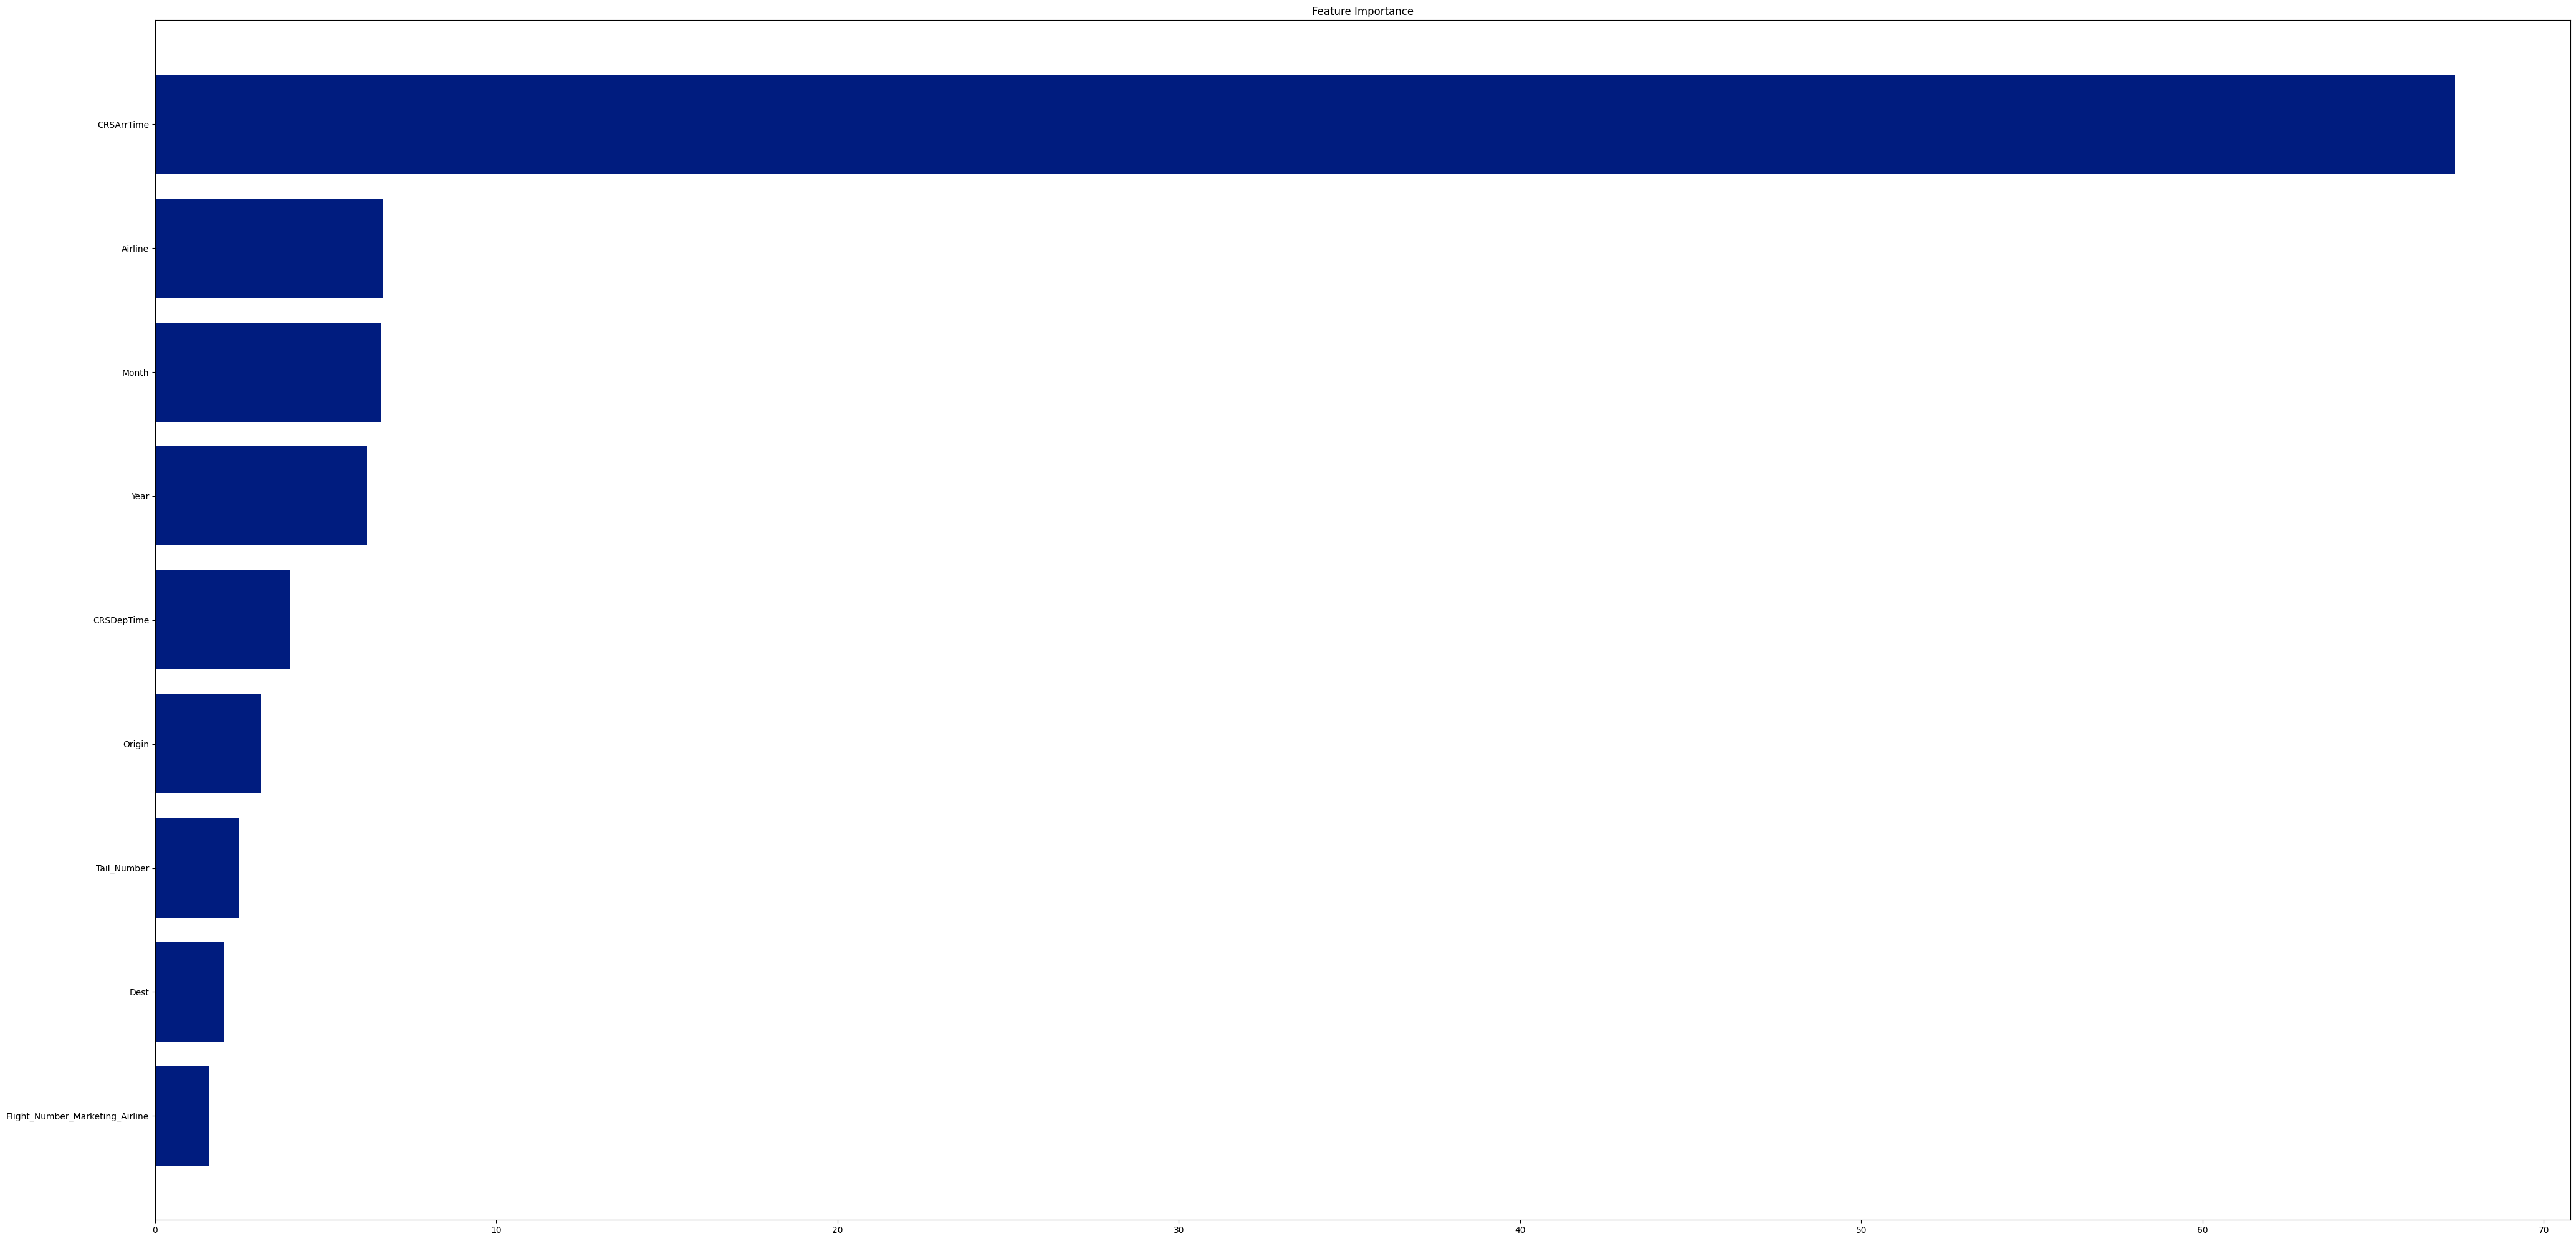

In [10]:
feature_importance = model_regressor.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(50, 25))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Text(0.5, 1.0, 'Permutation Importance')

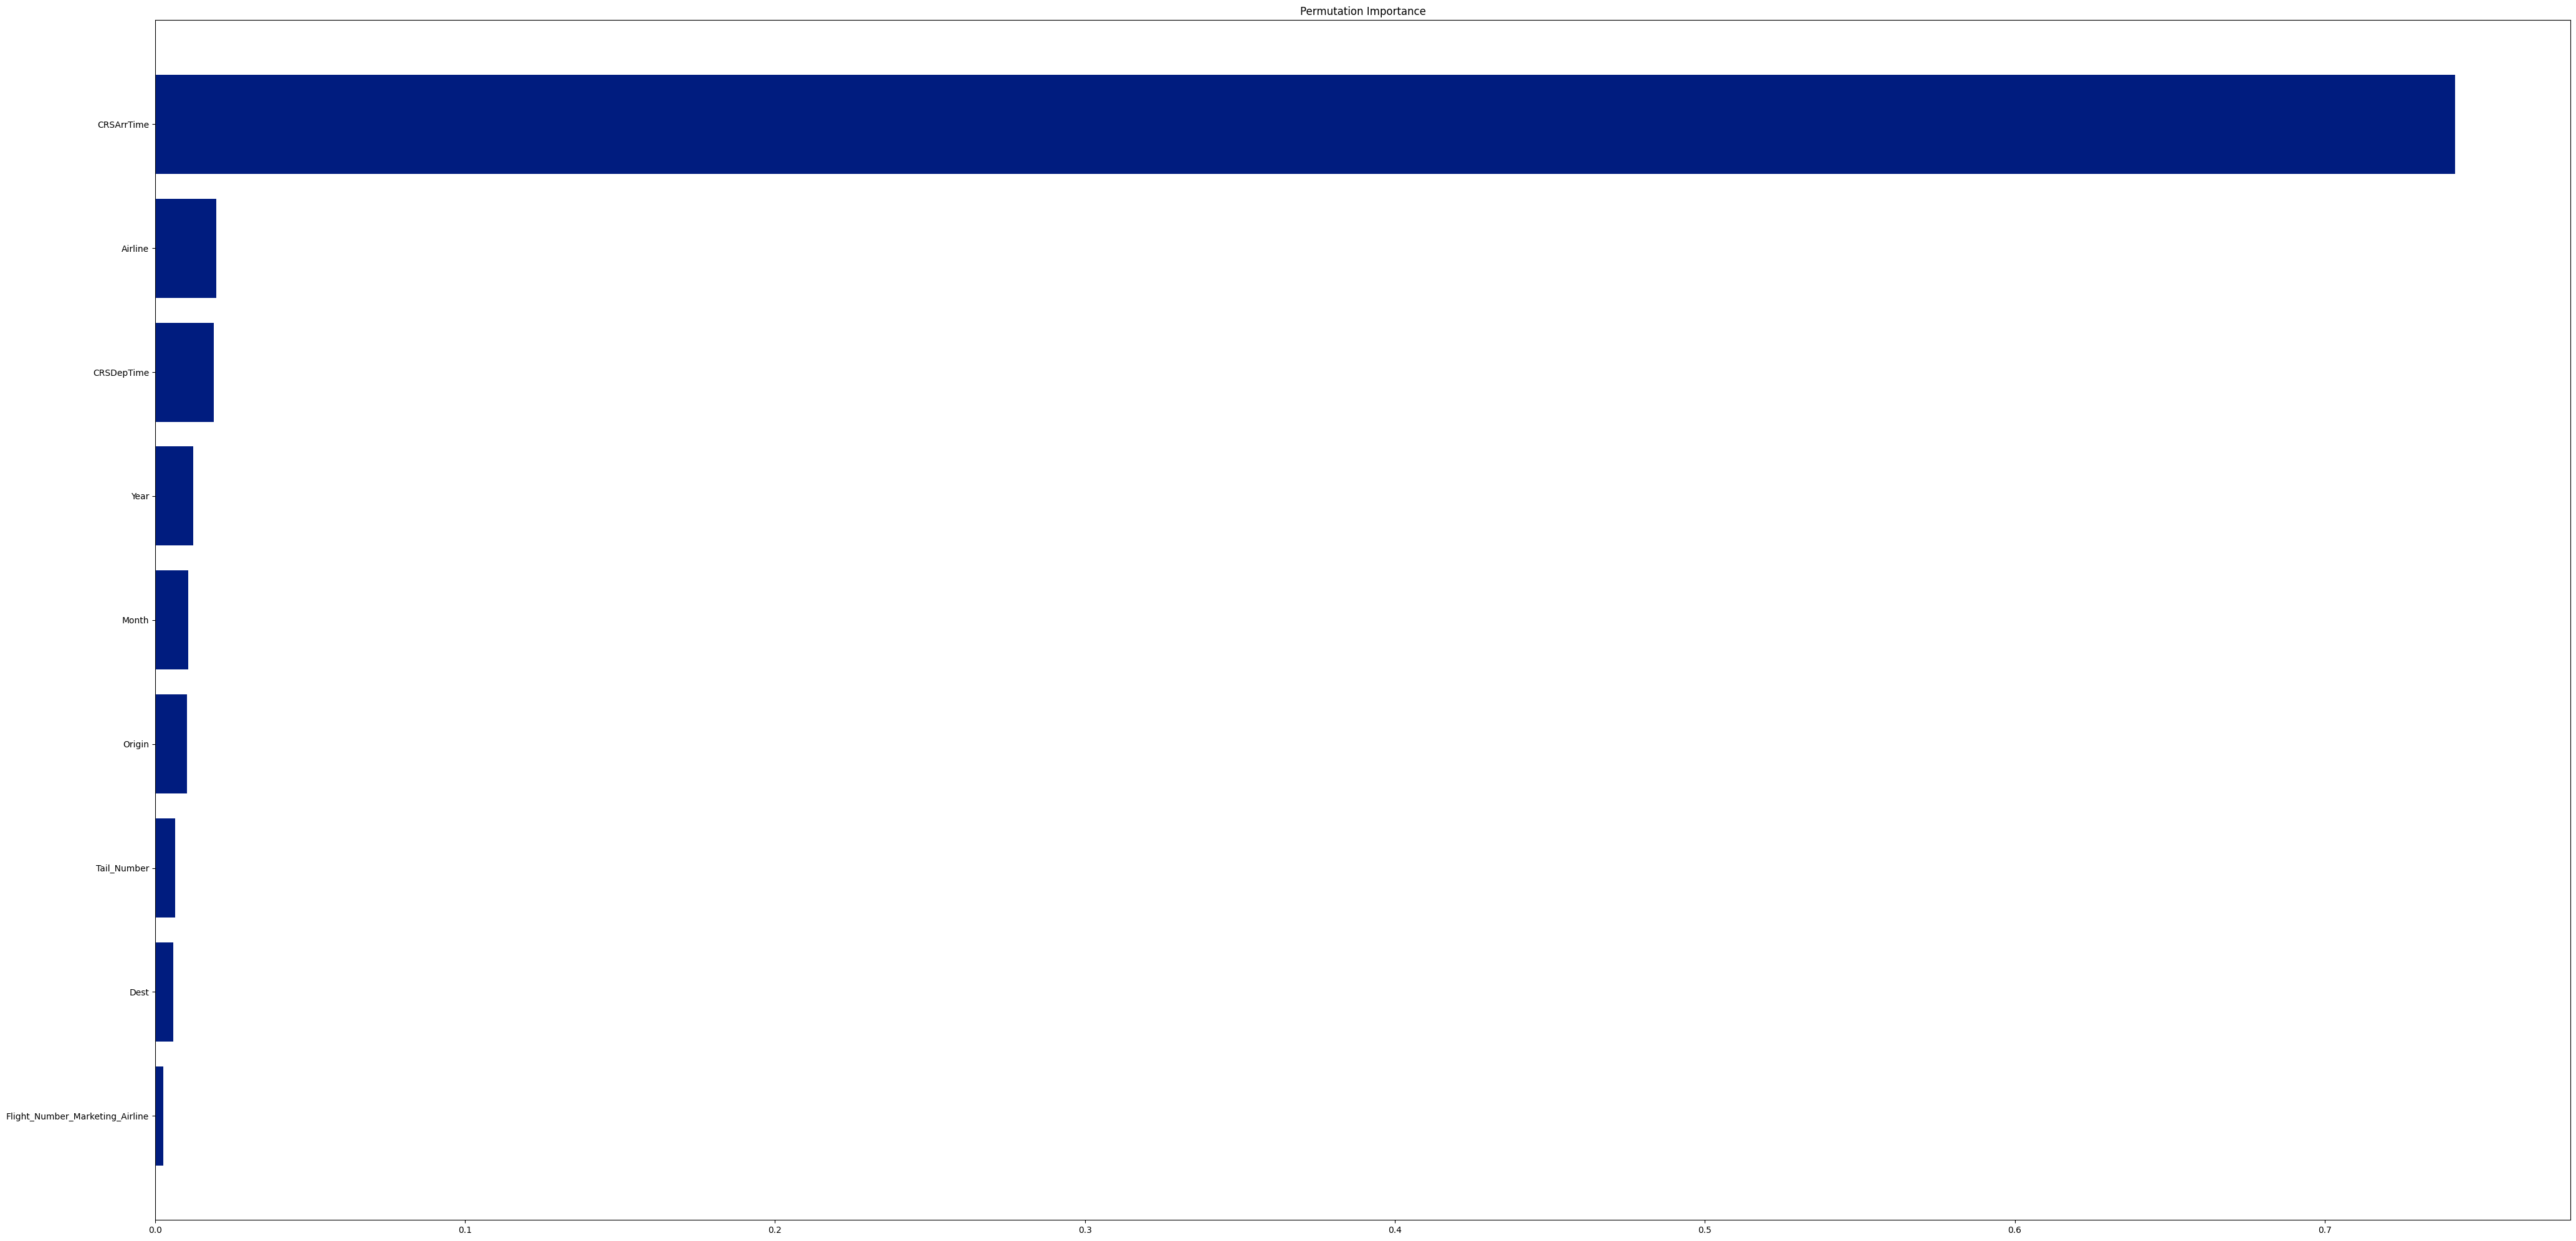

In [11]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(model_regressor, X_test, y_test, n_repeats=10, random_state=1066)
sorted_idx = perm_importance.importances_mean.argsort()
fig = plt.figure(figsize=(50, 25))
plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Permutation Importance')